In [1]:
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave,plot_single_plate
import matplotlib.patches as mpatches
import statsmodels.api as sm
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib widget
%load_ext autoreload
%autoreload 2
plt.style.use('presentation.mplstyle')

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
Css = {}
lambss = {}
dss = {}
meancurves = {}
meancurves2 = {}
t0ss = {}
timestep = {32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 65,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:150,152:35,792:60,1048:60,1045:50,941:50}
timestep2 = {102:25,83:70,76:20,81:70,32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 75,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:100,152:35,792:50,1048:60,1045:50}
timestep = {**timestep, **timestep2}
timestep2 = {1014 : 80,1024:25,1027:18,1028:60,1030 : 60,1032 : 50,1042 : 120,1048:70,127:120,129:60,130:50,991:40}
timestep = {**timestep, **timestep2}
timestep2 = {1023 : 60,1031:30,1035:30,1037 : 80,1039 : 90,1045:70,1047:50,1053:40}
timestep = {**timestep, **timestep2}    

timestep2 = {1071 : 25,1076:70,839:60,938 : 35}
timestep = {**timestep, **timestep2}
timestep2 = {30 : 62,32 : 160,33:80}
timestep = {**timestep, **timestep2}
timestep2 = {799 : 100,800 : 25,91:100,99:40}
timestep = {**timestep, **timestep2}

In [3]:
all_analysis_folders = get_analysis_folders()
plates = ['1014_20220525', '1023_20220502', '102_20201226', '1042_20220523',
       '1045_20220504', '1048_20220506', '1053_20220413', '1076_20220511',
       '127_20220705', '130_20220707', '152_20201224', '30_20220509',
       '32_20220428', '33_20220502', '52_20220707', '76_20210108',
       '792_20210915', '799_20211001', '800_20210928', '84_20220621','91_20220708', '938_20220325', '94_20201123']
plates = ['1014_20220525', '1023_20220502', '102_20201226', '1042_20220523',
       '1045_20220504', '1048_20220506', '1053_20220413', '1076_20220511',
       '127_20220705', '152_20201224', '30_20220509',
       '32_20220428', '33_20220502', '52_20220707', '76_20210108',
       '792_20210915', '799_20211001', '800_20210928', '84_20220621','91_20220708', '938_20220325', '94_20201123']
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders)
plate_select = [int(plate.split('_')[0]) for plate in plates]

In [4]:
def make_stat(x0,ax):
    def statistic(x,y):
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(x0,np.array(x0)*a+b,color = 'grey', alpha = 0.01)
        return(a)
    return(statistic)

In [5]:
plate_select = sorted(plate_select, key=lambda plate : get_order(plate,folders))

C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:253: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:253: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:253: UserWarning: This figure includes Axes that are not compatible with tight

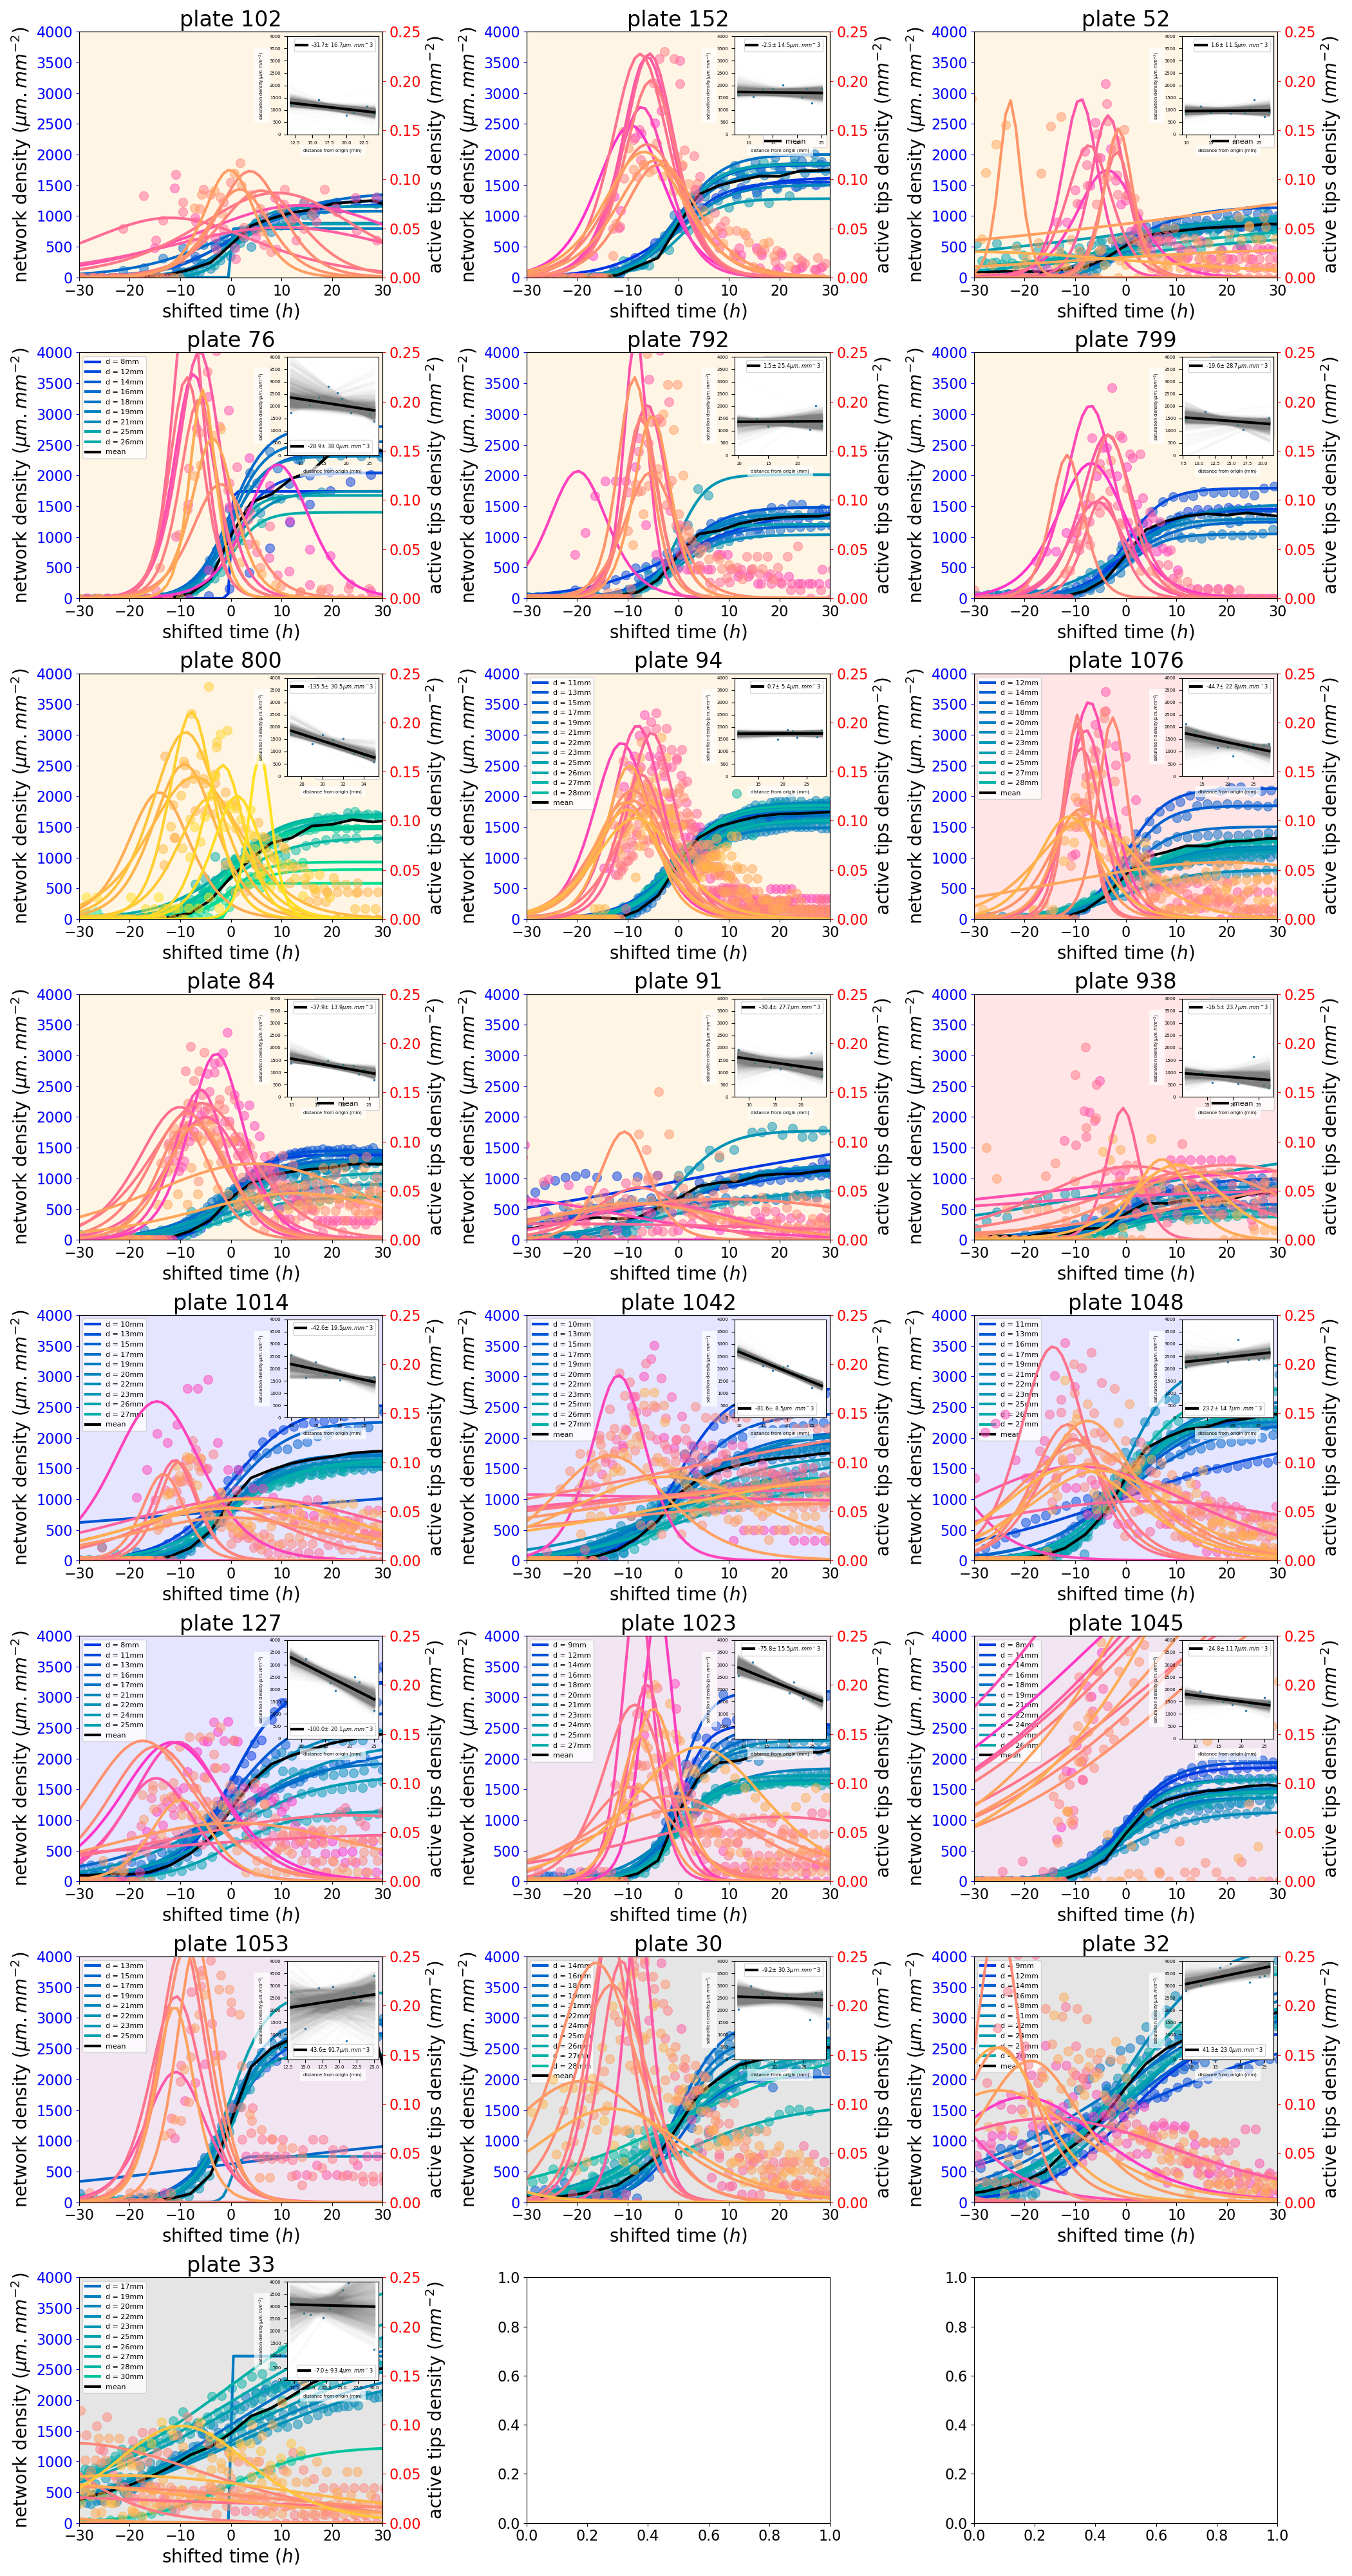

In [6]:
# plt.close('all')
ncols = 3
fig,axs = gridplot(len(plate_select),ncols = ncols,subh = 5,subw = 7)

maxis = {plate :12 for plate in plate_select}
maxis[94] = 13
maxis[152] = 11
maxis2 = {plate :12 for plate in plate_select}
maxis2[52] = 6
maxis2[938] = 7
# maxis[938] = 8

bbox = dict(facecolor='white', alpha = 0.7,edgecolor="None")

ax_list = list(axs)
for j in range(len(plate_select)):
    plate=plate_select[j]
    ax = ax_list[j]
    Cs, lambs,ds,indexes, t0s,meancurve,meancurve2 = plot_single_plate(plate,time_plate_info,timestep[plate],ax,maxi =maxis[plate])
    meancurves[plate]=meancurve
    meancurves2[plate]=meancurve2
    Css[plate] = Cs
    lambss[plate] = lambs
    dss[plate] = ds
    t0ss[plate] = t0s
    axins2 = inset_axes(ax, width="30%", height="40%", loc=1)
    x0 = np.linspace(np.min(ds),np.max(ds),10)
    statistic = make_stat(x0,axins2)

    data = np.array((ds,Cs))
    n_resamples=1000
    std = scipy.stats.bootstrap(data,statistic,
                                vectorized = False,
                                method="basic",
                                n_resamples = n_resamples,
                                paired= True).standard_error
    X = sm.add_constant(ds, prepend=False)
    model = sm.OLS(Cs,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    axins2.plot(ds,np.array(ds)*a+b,label = f"{round(a,1)}$\pm$ {round(std,1)}$\mu m.mm^{-3}$",color="black")
    axins2.scatter(ds,Cs,s = 2)
    axins2.set_ylim(0,4000)
    ax.set_ylim(0,4000)
    
    axins2.set_xlabel('distance from origin (mm)',size = 5,bbox=bbox)
    axins2.set_ylabel('saturation density($\mu m.mm^{-2}$)',size = 5,bbox=bbox)
    axins2.tick_params(labelsize = 5)
    axins2.legend(fontsize = 6)
    ax.patch.set_facecolor(get_color(plate,folders))
    ax.patch.set_alpha(0.1)
    # break
plt.savefig(f'Figure/FigureS2B.svg')    

In [ ]:
plates = plate_select
analysis_folders = analysis_folders.loc[analysis_folders['Plate'].isin(plates)]
folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders)
folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders)

C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\1045_20220504\Analysis_1045_20220504_189_Version1\time_hypha_info\hyph_info_44.json
C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\1045_20220504\Analysis_1045_20220504_189_Version1\time_hypha_info\hyph_info_45.json
C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\1045_20220504\Analysis_1045_20220504_189_Version1\time_hypha_info\hyph_info_46.json
C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\1045_20220504\Analysis_1045_20220504_189_Version1\time_hypha_info\hyph_info_47.json
C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\1045_20220504\Analysis_1045_20220504_189_Version1\time_hypha_info\hyph_info_54.json
C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\1045_20220504\Analysis_1045_20220504_189_Version1\time_hypha_info\hyph_info_55.json
C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\1045_20220504\Analysis_1045_20220504_189_Version1\time_hypha_info\hyph_info_56.json
C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\1045_20220504\Analys

In [ ]:
plate

In [ ]:
ncols = 3
fig,axs = gridplot(len(plate_select),ncols = ncols,subh = 5,subw = 7)
ax_list = list(axs)
for j in range(len(plate_select)):
    plate=plate_select[j]
    ax = ax_list[j]
    hull_speeds = []
    hull_time = []
    time_hypha_plate = time_hypha_info.loc[time_hypha_info['unique_id'].astype(str).str[:len(str(plate))]==str(plate)]

    data,dy,select_movements = get_average_time_data(plate,time_hypha_info,2)
    hyphae_hull = get_hyphae_hull(plate,analysis_folders)
    if len(hyphae_hull)>0:
        label = 'hull pusher'
        for t in range(1,len(time_hypha_plate['timestep'].unique())-1):
            select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
            select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
            select = select.loc[select['speed'].between(150,350)]
            if len(select)>0:
                time = select['time_since_begin_h'].iloc[0]
                if time/pd.Timedelta(hours = 1)<=100:
                    ax.scatter(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1),np.mean(select["speed"]),color='black')
                    ax.errorbar(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1),np.mean(select["speed"]),np.std(select["speed"])/np.sqrt(len(select)),color='black',label=label)
                    label = None
                    hull_speeds.append(np.mean(select["speed"]))
                    hull_time.append(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1))

                select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
                # select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
        # ax.plot(data.index/pd.Timedelta(hours = 1),data)
        ax.errorbar(data.index/pd.Timedelta(hours = 1),data, yerr=dy,label='average')
        ax.set_xlim(0,150)
        ax.set_ylim(150,350)

        ax.legend()
        # ax.set_title(f'{plate}')
        ax.set_xlabel('time since begin (h)')
        ax.set_ylabel('speed ($\mu m.h^{-1}$)')
            # break
        ax.set_xlim(0,100)
        plt.tight_layout()
        ax.plot(hull_time,[np.mean(hull_speeds)]*len(hull_time),
                color="black",
                label= f'mean hull pusher speed {int(np.nanmean(hull_speeds))}$\pm${int(2*np.nanstd(hull_speeds)/np.sqrt(len(hull_speeds)))} $\mu m.h^{-1}$')
        ax.legend()
    # break
plt.savefig(f'Figure/FigureS1C.svg')    

In [ ]:
plt.savefig(f'Figure/FigureS1C.svg')    

In [ ]:
fig,axs = gridplot(len(plate_select),ncols = ncols,subh = 4.0,subw = 6)

maxis = {plate :12 for plate in plate_select}
maxis[52] = 6
maxis[938] = 7


ax_list = list(axs)
for j in range(len(plate_select)):
    plate=plate_select[j]
    ax = ax_list[j]
    t0s = t0ss[plate][:maxis[plate]]
    ds = dss[plate][:maxis[plate]]
    ax.scatter(t0s,ds,label = "data")
    def statistic(t0s,ds):
        X = sm.add_constant(t0s, prepend=False)
        model = sm.OLS(ds,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(t0s,np.array(t0s)*a+b,color = 'grey', alpha = 0.01)

        return(a)
    data = np.array((t0s,ds))
    n_resamples=1000
    std = scipy.stats.bootstrap(data,statistic,
                                vectorized = False,
                                method="basic",
                                n_resamples = n_resamples,
                                paired= True).standard_error
    X = sm.add_constant(t0s, prepend=False)
    model = sm.OLS(ds,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    ax.plot(t0s,np.array(t0s)*a+b,label = f"linear fit : speed = {int(1000*a)}$\pm$ {int(1000*std)}$\mu m.h^{-1}$")
    ax.legend()
    ax.set_ylabel('distance from center (mm)')
    ax.set_xlabel('time of wave crossing (hours)')
    ax.set_title(f'Plate {plate}')
    plt.tight_layout()
    plt.savefig(f'Figure/FigureS1C.svg')


In [ ]:
fig, ax = plt.subplots()
def statistic(ds,Cs):
    X = sm.add_constant(ds, prepend=False)
    model = sm.OLS(Cs,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    color = plt.gca().lines[-1].get_color()
    ax.plot(ds,np.array(ds)*a+b,color = color, alpha = 0.01)
    return(a)

tot_ds = []
tot_Cs=[]

for plate in plate_select:
    Cs = Css[plate]
    ds = dss[plate]
    tot_ds+=ds
    tot_Cs+=Cs
    ax.scatter(ds,Cs,alpha = 0.2)
    
    X = sm.add_constant(ds, prepend=False)
    model = sm.OLS(Cs,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    ax.plot(ds,np.array(ds)*a+b,label=plate)
    data = np.array((ds,Cs))
    
#     n_resamples=1000
#     std = scipy.stats.bootstrap(data,statistic,
#                                 vectorized = False,
#                                 method="basic",
#                                 n_resamples = n_resamples,
#                                 paired= True).standard_error
# X = sm.add_constant(tot_ds, prepend=False)
# model = sm.OLS(tot_Cs,X)
# res = model.fit()
# a,b = res.params[0],res.params[1]
# ax.plot(tot_ds,np.array(tot_ds)*a+b,color = 'black')
df = pd.DataFrame((tot_ds,tot_Cs)).transpose()
df.columns = ('distance','saturation density')
data = np.array((tot_ds,tot_Cs))
# n_resamples=10000
# std = scipy.stats.bootstrap(data,statistic,
#                             vectorized = False,
#                             method="basic",
#                             n_resamples = n_resamples,
#                             paired= True).standard_error

# data = df.groupby('distance').mean()
# ax.plot(data.index,data,label="average",color='black',linewidth=10,alpha = 0.5)    
ax.legend()
ax.set_xlabel('distance from origin (mm)')
ax.set_ylabel('saturation density($\mu m.mm^{-1}$)')
plt.tight_layout()
plt.savefig(f'Figure/FigureS1Bsubset.svg')    
# ax.set_ylim(0,2500)


In [ ]:
std

In [ ]:
fig, ax = plt.subplots()
tot_ds = []
tot_Cs=[]
for plate in plate_select:
# for plate in [938]:
    t0s = t0ss[plate][:maxis[plate]]
    ds = dss[plate][:maxis[plate]]
    X = sm.add_constant(t0s, prepend=False)
    model = sm.OLS(ds,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    x = np.array(t0s)+b/a
    ax.plot(x,np.array(t0s)*a+b,label = f"{plate} : speed = {int(1000*a)}$\mu m.h^{-1}$")
    ax.scatter(x,ds)
    
ax.legend()
ax.set_ylabel('distance from center (mm)')
ax.set_xlabel('time of wave crossing (hours)')
plt.tight_layout()
plt.savefig(f'Figure/FigureS1C2.svg')    

In [ ]:
strains = ["'A5'","'A5sp3'"]
plates = [plate for plate in folders['unique_id'].unique() if folders.loc[folders['unique_id']==plate].iloc[0]['strain'] in strains]
treatments = ["'001P100N100C'","'001P100N'"]
plates = [plate for plate in plates if folders.loc[folders['unique_id']==plate].iloc[0]['medium'] in treatments]
plates.remove(87720220419)
plates.remove(40320221005)
plates.remove(90720220321)

In [ ]:
# plt.close('all')
ncols = 3
fig,axs = gridplot(len(plates),ncols = ncols,subh = 4.0,subw = 8)
maxis = {plate :12 for plate in plates}
for i in range(len(plates)):
    plate=plates[i]
    ax = axs[i]
    Cs, lambs,ds,indexes, t0s,meancurve,meancurve2 = plot_single_plate(plate,time_plate_info,timestep[int(str(plate)[:-8])],ax,maxi =maxis[plate],unique_id = True)
    meancurves[plate]=meancurve
    meancurves2[plate]=meancurve2
    Css[plate] = Cs
    lambss[plate] = lambs
    dss[plate] = ds
    t0ss[plate] = t0s

In [ ]:
# plt.close('all')
fig, ax = plt.subplots()

ax2 = ax.twinx()

for plate in plates:
    meancurve = meancurves[plate]
    meancurve2 = meancurves2[plate]
    ax.plot(meancurve.index,meancurve,label=int(str(plate)[:-8]))
    ax2.plot(meancurve.index,meancurve2,label=int(str(plate)[:-8]),linestyle="dashed")
ax.set_xlim((-30,30))
ax2.set_ylim((0,0.2))

ax.set_ylabel('network density ($\mu m.mm^{-2}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel('active tips density ($mm^{-2}$)')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
plt.legend()
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots()
tot_ds = []
tot_Cs=[]
# plates = [52,152,94,102,83,84,792,76]

for plate in plates:
    if int(str(plate)[:-8]) not in [91,89,56]:
        Cs = Css[plate]
        ds = dss[plate]
        tot_ds+=ds
        tot_Cs+=Cs
        ax.plot(ds,Cs,label = int(str(plate)[:-8]))
df = pd.DataFrame((tot_ds,tot_Cs)).transpose()
df.columns = ('distance','saturation density')
data = df.groupby('distance').mean()
ax.plot(data.index,data,label="average",color='black',linewidth=10,alpha = 0.5)    
ax.legend()
ax.set_xlabel('distance from origin (mm)')
ax.set_ylabel('saturation density ($\mu m.mm^{-1}$)')
plt.tight_layout()